In [2]:
pip install pandas requests beautifulsoup4 matplotlib scikit-learn statsmodels xgboost pmdarima selenium

Note: you may need to restart the kernel to use updated packages.


In [19]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import sys
import os
def setup_chrome_driver():
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-plugins")
    chrome_options.add_argument("--disable-images")
    chrome_options.add_argument("--disable-background-timer-throttling")
    chrome_options.add_argument("--disable-backgrounding-occluded-windows")
    chrome_options.add_argument("--disable-renderer-backgrounding")
    chrome_options.add_argument("--disable-features=TranslateUI")
    chrome_options.add_argument("--disable-ipc-flooding-protection")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_experimental_option('useAutomationExtension', False)
    chrome_options.add_argument("--aggressive-cache-discard")
    chrome_options.page_load_strategy = 'none'
    if sys.platform.startswith('linux'):
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--remote-debugging-port=9222")
    try:
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        return driver
    except Exception as e:
        print(f"Error occured.")
        try:
            driver = webdriver.Chrome(options=chrome_options)
            return driver
        except Exception as e2:
            print(f"Error occured.")
            print("Please ensure Chrome browser is installed and ChromeDriver is available.")
            raise
def scrape_gold_data():
    driver = setup_chrome_driver()
    driver.set_page_load_timeout(10)
    driver_wait = WebDriverWait(driver, 3)
    try:
        driver.get("https://economictimes.indiatimes.com/markets/gold-rate-in-india-today")
        driver_wait.until(EC.presence_of_element_located((By.TAG_NAME, "table")))
        section_24k = driver.find_element(By.ID, "monthTrend24c")
        driver.execute_script("arguments[0].scrollIntoView(true);", section_24k)        
        tables_data = driver.execute_script("""
            var dailyTable = document.querySelector('table.table.lg_txt.rf_rr');
            var monthlyTable = document.querySelector('#monthTrend24c table');
            var dailyRows = Array.from(dailyTable.querySelectorAll('tr')).slice(1);
            var monthlyRows = Array.from(monthlyTable.querySelectorAll('tbody tr'));
            var dailyData = dailyRows.map(row => {
                var cells = row.querySelectorAll('td');
                if (cells.length >= 3) {
                    return {
                        date: cells[0].textContent.trim(),
                        price: cells[2].querySelector('.text').textContent.trim()
                    };
                }
                return null;
            }).filter(item => item !== null);
            var monthlyData = monthlyRows.map(row => {
                var cells = row.querySelectorAll('td');
                if (cells.length >= 6) {
                    return {
                        month: cells[0].textContent.trim(),
                        start: cells[1].textContent.trim(),
                        end: cells[2].textContent.trim(),
                        change: cells[3].querySelector('span') ? cells[3].querySelector('span').textContent.trim() : cells[3].textContent.trim(),
                        percent: cells[4].querySelector('span') ? cells[4].querySelector('span').textContent.trim() : cells[4].textContent.trim(),
                        average: cells[5].textContent.trim()
                    };
                }
                return null;
            }).filter(item => item !== null);
            return {daily: dailyData, monthly: monthlyData};
        """)        
        daily_data = []
        for item in tables_data['daily']:
            date_text = item['date']
            raw_price = item['price']
            numeric_str = raw_price.replace('₹', '').replace(',', '')
            try:
                price_value = float(numeric_str) / 10  
            except ValueError:
                price_value = None
            daily_data.append({
                'Date': date_text,
                'Price_per_gram': price_value
            })
        daily_df = pd.DataFrame(daily_data)
        daily_df.to_excel('daily_gold.xlsx', index=False)
        print(f"Saved daily data to 'daily_gold.xlsx'.")
        monthly_data = []
        for item in tables_data['monthly']:
            month = item['month']
            start_price = item['start'].replace('₹', '').replace(',', '')
            end_price = item['end'].replace('₹', '').replace(',', '')
            change_value = item['change']
            percent_change = item['percent']
            average_price = item['average'].replace('₹', '').replace(',', '')
            try:
                start_val = float(start_price)
                end_val = float(end_price)
                avg_val = float(average_price)
            except ValueError:
                start_val = end_val = avg_val = None
            monthly_data.append({
                'Month': month,
                'Start_per_gram': start_val,
                'End_per_gram': end_val,
                'Change_Rs': change_value,
                'Percent_change': percent_change,
                'Average_per_gram': avg_val
            })
        monthly_df = pd.DataFrame(monthly_data)
        monthly_df.to_excel('monthly_gold.xlsx', index=False)
        print(f"Saved monthly data to 'monthly_gold.xlsx'.")
    except Exception as e:
        print(f"Error occured.")
        raise
    finally:
        driver.quit()
if __name__ == "__main__":
    required_packages = ['selenium', 'pandas', 'webdriver-manager', 'openpyxl']
    missing_packages = []
    for package in required_packages:
        try:
            if package == 'webdriver-manager':
                import webdriver_manager
            elif package == 'openpyxl':
                import openpyxl
            else:
                __import__(package)
        except ImportError:
            missing_packages.append(package)
    if missing_packages:
        print("Missing required packages. Please install them using:")
        print(f"pip install {' '.join(missing_packages)}")
        sys.exit(1)
    scrape_gold_data()

Saved daily data to 'daily_gold.xlsx'.
Saved monthly data to 'monthly_gold.xlsx'.


In [31]:
import pandas as pd
try:
    daily_df = pd.read_excel('daily_gold.xlsx')
    monthly_df = pd.read_excel('monthly_gold.xlsx')
    print("Successfully loaded 'daily_gold.xlsx' and 'monthly_gold.xlsx'.")
    print("The data is as follows:")
except FileNotFoundError:
    print("Make sure 'daily_gold.xlsx' and 'monthly_gold.xlsx' are in the same directory as the notebook.")
    daily_df = None
    monthly_df = None
if monthly_df is not None:
    print("\nMonthly Gold Prices (displayed upto first 5 rows):")
    print(monthly_df.head())    
if daily_df is not None:
    print("\nDaily Gold Prices (displayed upto first 5 rows):")
    print(daily_df.head())
if daily_df is not None:
    daily_df['Date'] = pd.to_datetime(daily_df['Date'], format='%b %d, %Y')
    daily_df.set_index('Date', inplace=True)
    daily_df.sort_index(inplace=True)

Successfully loaded 'daily_gold.xlsx' and 'monthly_gold.xlsx'.
The data is as follows:

Monthly Gold Prices (displayed upto first 5 rows):
         Month  Start_per_gram  End_per_gram Change_Rs Percent_change  \
0     April 25            7673          7641      ₹-32         -0.42%   
1     March 25            7646          7634      ₹-12         -0.16%   
2  February 25            7534          7646      ₹112          1.49%   
3   January 25            7636          7534     ₹-102         -1.34%   
4  December 24            7595          7600        ₹5          0.07%   

   Average_per_gram  
0              7611  
1              7635  
2              7620  
3              7608  
4              7605  

Daily Gold Prices (displayed upto first 5 rows):
           Date  Price_per_gram
0  May 29, 2025            7555
1  May 28, 2025            7554
2  May 24, 2025            7614
3  May 22, 2025            7656
4  May 13, 2025            7650


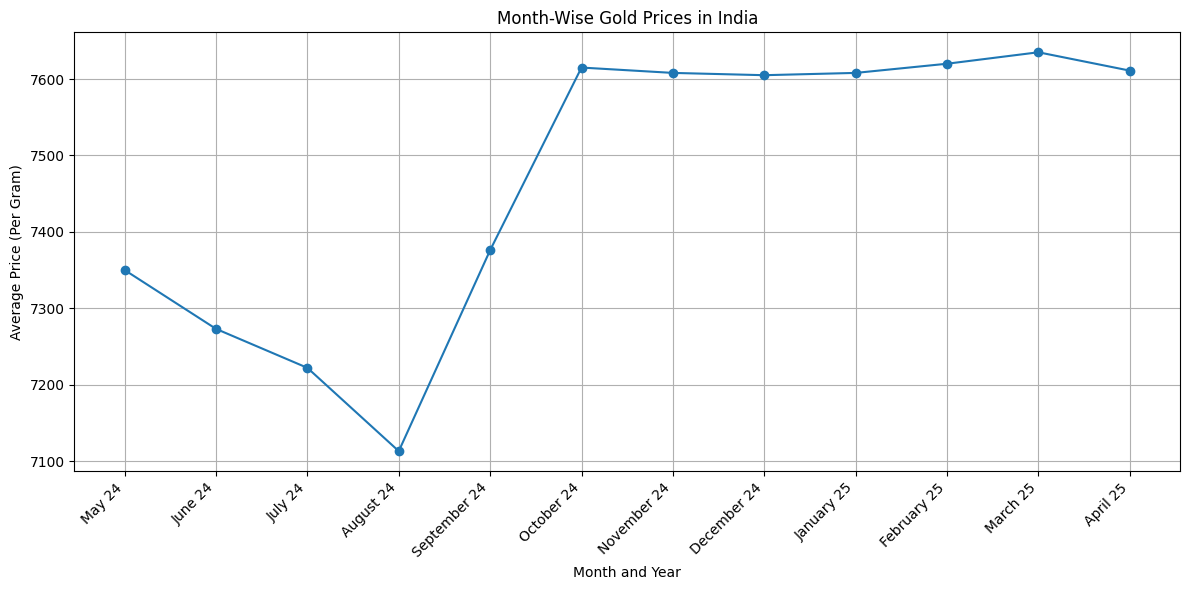

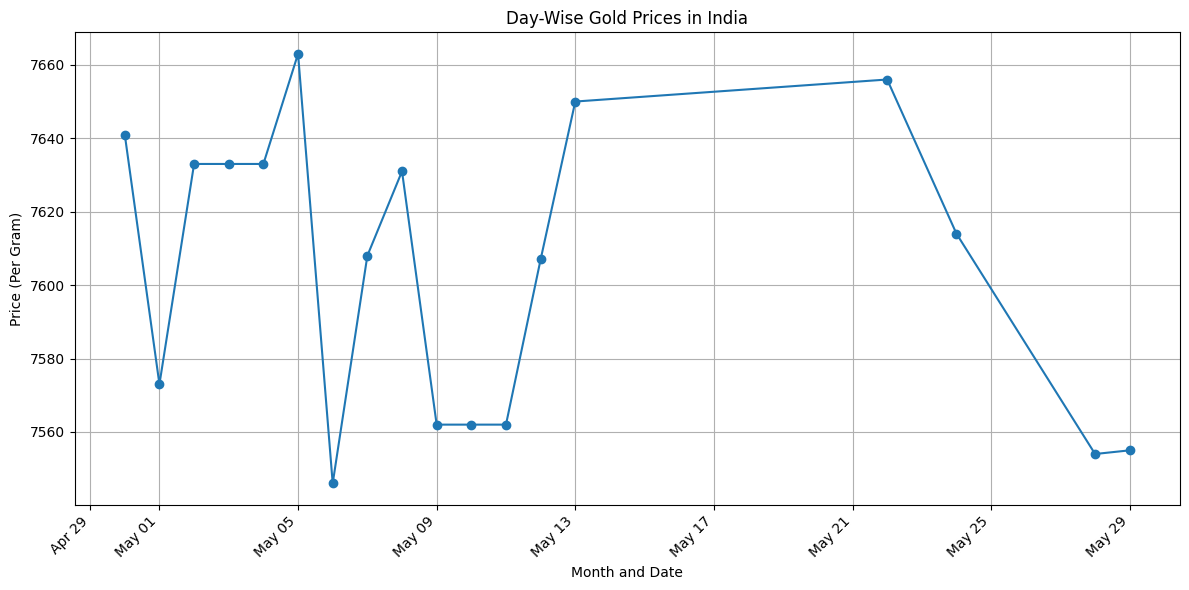

In [21]:
import matplotlib.pyplot as plt
if 'monthly_df' in locals() and monthly_df is not None:
    monthly_df.sort_index(inplace=True)
    monthly_df = monthly_df[::-1]
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_df['Month'], monthly_df['Average_per_gram'], marker='o', linestyle='-')
    plt.title('Month-Wise Gold Prices in India')
    plt.xlabel('Month and Year')
    plt.ylabel('Average Price (Per Gram)')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Monthly data not available for plotting. Please run the initial data loading cell.")
if 'daily_df' in locals() and daily_df is not None:
    daily_df.sort_index(inplace=True)
    plt.figure(figsize=(12, 6))
    plt.plot(daily_df.index, daily_df['Price_per_gram'], marker='o', linestyle='-')
    plt.title('Day-Wise Gold Prices in India')
    plt.xlabel('Month and Date')
    plt.ylabel('Price (Per Gram)')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right') 
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
    plt.tight_layout() 
    plt.show()
else:
    print("Daily data not available for plotting. Please run the initial data loading cell.")

In [33]:
if monthly_df is not None:
    monthly_data_ts = monthly_df['Average_per_gram'].values    
    if monthly_data_ts is not None and len(monthly_data_ts) > 3:
        test_size_monthly = 3
        train_data_monthly, test_data_monthly = monthly_data_ts[:-test_size_monthly], monthly_data_ts[-test_size_monthly:]
        print(f"Total Monthly Data Size: {len(monthly_data_ts)}")
        print(f"Monthly Training Data Size: {len(train_data_monthly)}")
        print(f"Monthly Testing Data Size: {len(test_data_monthly)}")
        print("\nMonthly Training Data (displayed upto first 5 rows):")
        print(monthly_df.iloc[:-test_size_monthly][['Month', 'Average_per_gram']].head().to_string(index=False))
        print("\nMonthly Testing Data (All Rows):")
        print(monthly_df.iloc[-test_size_monthly:][['Month', 'Average_per_gram']].to_string(index=False))
    elif monthly_data_ts is not None:
        print("Monthly data is too small.")
    else:
        print("Monthly data not available.")
else:
    monthly_data_ts = None

Total Monthly Data Size: 12
Monthly Training Data Size: 9
Monthly Testing Data Size: 3

Monthly Training Data (displayed upto first 5 rows):
      Month  Average_per_gram
   April 25              7611
   March 25              7635
February 25              7620
 January 25              7608
December 24              7605

Monthly Testing Data (All Rows):
  Month  Average_per_gram
July 24              7222
June 24              7273
 May 24              7350


In [34]:
if 'monthly_data_ts' in locals() and monthly_data_ts is not None and 'train_data_monthly' in locals() and train_data_monthly is not None and 'test_data_monthly' in locals() and test_data_monthly is not None:
    import numpy as np
    import pandas as pd
    from statsmodels.tsa.holtwinters import Holt
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import warnings
    warnings.filterwarnings('ignore')
    actual_months = []
    for month_str in monthly_df['Month']:
        month_parts = month_str.split()
        month_name = month_parts[0]
        year = int('20' + month_parts[1])
        month_dict = {
            'January': 1, 'February': 2, 'March': 3, 'April': 4,
            'May': 5, 'June': 6, 'July': 7, 'August': 8,
            'September': 9, 'October': 10, 'November': 11, 'December': 12}
        month_num = month_dict[month_name]
        actual_months.append(pd.Timestamp(year=year, month=month_num, day=1))
    actual_months.reverse()
    monthly_series = pd.Series(monthly_data_ts[::-1], index=actual_months)
    train_series_monthly = monthly_series.iloc[:-3]
    test_series_monthly = monthly_series.iloc[-3:]
    def evaluate_holt_model(train_data, test_data, alpha, beta, phi=None, damped=False):
        try:
            if damped:
                model = Holt(train_data, exponential=False, damped_trend=True)
                fitted = model.fit(smoothing_level=alpha, smoothing_trend=beta, damping_trend=phi, optimized=False)
            else:
                model = Holt(train_data, exponential=False)
                fitted = model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
            predictions = fitted.forecast(steps=len(test_data))
            predictions.index = test_data.index
            rmse = np.sqrt(mean_squared_error(test_data, predictions))
            return rmse, predictions, fitted
        except:
            return float('inf'), None, None
    alpha_values = [0.8, 0.85, 0.9, 0.95, 0.99, 0.995]
    beta_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.284, 0.3, 0.35]
    phi_values = [0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
    best_rmse_regular = float('inf')
    best_params_regular = None
    best_predictions_regular = None
    best_model_regular = None
    for alpha in alpha_values:
        for beta in beta_values:
            rmse, predictions, model = evaluate_holt_model(train_series_monthly, test_series_monthly, alpha, beta, damped=False)
            if rmse < best_rmse_regular:
                best_rmse_regular = rmse
                best_params_regular = (alpha, beta)
                best_predictions_regular = predictions
                best_model_regular = model
    best_rmse_damped = float('inf')
    best_params_damped = None
    best_predictions_damped = None
    best_model_damped = None
    for alpha in alpha_values:
        for beta in beta_values:
            for phi in phi_values:
                rmse, predictions, model = evaluate_holt_model(train_series_monthly, test_series_monthly, alpha, beta, phi=phi, damped=True)
                if rmse < best_rmse_damped:
                    best_rmse_damped = rmse
                    best_params_damped = (alpha, beta, phi)
                    best_predictions_damped = predictions
                    best_model_damped = model
    if best_rmse_regular < best_rmse_damped:
        best_method = "Regular"
        best_rmse = best_rmse_regular
        best_params = best_params_regular
        best_predictions = best_predictions_regular
        best_model = best_model_regular
        method_details = f"Alpha = {best_params[0]}, Beta = {best_params[1]}"
    else:
        best_method = "Damped"
        best_rmse = best_rmse_damped
        best_params = best_params_damped
        best_predictions = best_predictions_damped
        best_model = best_model_damped
        method_details = f"Alpha = {best_params[0]}, Beta = {best_params[1]}, Phi = {best_params[2]}"
    if best_predictions is not None:
        mae = mean_absolute_error(test_series_monthly, best_predictions)
        print("For the month-wise data:\n")
        print(f"{best_method} Holt's Predictions Approach is at play here; with the following parameters:")
        print(method_details)
        print("\nTesting on Known Values:")
        print("Month_Year    Actual    Predicted    Error      % Error")
        print("-" * 55)
        for date in test_series_monthly.index:
            actual = test_series_monthly[date]
            pred = best_predictions[date]
            error = actual - pred
            pct_error = (error / actual) * 100
            month_abbr = date.strftime('%b %y')
            print(f"{month_abbr}        {actual:.0f}     {pred:.2f}     {error:+6.2f}     {pct_error:+5.1f}%")
        pred_std = best_predictions.std()
        pred_range = best_predictions.max() - best_predictions.min()
        print(f"\nRMSE: {best_rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"\nStandard Deviation: ₹{pred_std:.2f}")
        print(f"Range: ₹{pred_range:.2f}\n")
        print("="*50)  
        print("\nFor the Next 3 Months:")
        if best_method == "Damped":
            full_model = Holt(monthly_series, exponential=False, damped_trend=True)
            full_fitted = full_model.fit(
                smoothing_level=best_params[0], 
                smoothing_trend=best_params[1], 
                damping_trend=best_params[2],
                optimized=False
            )
        else:
            full_model = Holt(monthly_series, exponential=False)
            full_fitted = full_model.fit(
                smoothing_level=best_params[0], 
                smoothing_trend=best_params[1], 
                optimized=False
            )
        future_forecast = full_fitted.forecast(steps=3)
        last_value = monthly_series.iloc[-1]
        print(f"Last Known Price: ₹{last_value:.2f}\n")
        print("Month_Year    Price        Change    Cumulative Change")
        print("-" * 55)
        prev_price = last_value
        for i, price in enumerate(future_forecast):
            future_date = monthly_series.index[-1] + pd.DateOffset(months=i+1)
            change = price - prev_price
            cum_change = price - last_value
            month_abbr = future_date.strftime('%b %y')
            print(f"{month_abbr}        ₹{price:.2f}     {change:+6.2f}      {cum_change:+6.2f}")
            prev_price = price
    else:
        print("Unable to fit Holt model with the given parameters.")   
else:
    print("Monthly data not available. Please run the data loading cells.")

For the month-wise data:

Damped Holt's Predictions Approach is at play here; with the following parameters:
Alpha = 0.9, Beta = 0.1, Phi = 0.8

Testing on Known Values:
Month_Year    Actual    Predicted    Error      % Error
-------------------------------------------------------
Feb 25        7620     7615.84      +4.16      +0.1%
Mar 25        7635     7621.47     +13.53      +0.2%
Apr 25        7611     7625.97     -14.97      -0.2%

RMSE: 11.89
MAE: 10.89

Standard Deviation: ₹5.07
Range: ₹10.13


For the Next 3 Months:
Last Known Price: ₹7611.00

Month_Year    Price        Change    Cumulative Change
-------------------------------------------------------
May 25        ₹7616.14      +5.14       +5.14
Jun 25        ₹7617.97      +1.83       +6.97
Jul 25        ₹7619.43      +1.46       +8.43


In [35]:
if 'daily_df' in locals() and daily_df is not None:
    total_daily_entries = len(daily_df)
    test_size_daily_specific = 3
    if total_daily_entries >= test_size_daily_specific:
        train_size_daily_actual = total_daily_entries - test_size_daily_specific
        train_data_daily_specific = daily_df.iloc[:train_size_daily_actual]
        test_data_daily_specific = daily_df.iloc[-test_size_daily_specific:]
        print("Total Daily Data Size:", total_daily_entries)
        print("Daily Training Data Size:", len(train_data_daily_specific))
        print("Daily Testing Data Size:", len(test_data_daily_specific))
        print("\nDaily Training Data (displayed upto first 5 rows):")
        print(train_data_daily_specific.head())
        print("\nDaily Testing Data (All Rows):")
        print(test_data_daily_specific) 
    else:
        print("Daily data is too small.")
        train_data_daily_specific = None
        test_data_daily_specific = None
else:
    print("Daily data not available. Please run the data loading cells.")
    train_data_daily_specific = None
    test_data_daily_specific = None

Total Daily Data Size: 18
Daily Training Data Size: 15
Daily Testing Data Size: 3

Daily Training Data (displayed upto first 5 rows):
            Price_per_gram
Date                      
2025-04-30            7641
2025-05-01            7573
2025-05-02            7633
2025-05-03            7633
2025-05-04            7633

Daily Testing Data (All Rows):
            Price_per_gram
Date                      
2025-05-24            7614
2025-05-28            7554
2025-05-29            7555


In [36]:
if 'train_data_daily_specific' in locals() and train_data_daily_specific is not None and 'test_data_daily_specific' in locals() and test_data_daily_specific is not None and 'daily_df' in locals() and daily_df is not None:
    import numpy as np
    import pandas as pd
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import warnings
    warnings.filterwarnings('ignore')
    class HoltMethod:
        def __init__(self, alpha=0.3, beta=0.1, damped=False, phi=0.98):
            self.alpha = alpha
            self.beta = beta
            self.damped = damped
            self.phi = phi if damped else 1.0
            self.level = None
            self.trend = None
            self.fitted_values = []
        def fit(self, data):
            values = data.values if hasattr(data, 'values') else data
            n = len(values)   
            self.level = values[0]
            if n > 1:
                self.trend = values[1] - values[0]
            else:
                self.trend = 0            
            self.fitted_values = [self.level]
            for t in range(1, n):
                prev_level = self.level
                prev_trend = self.trend
                self.level = self.alpha * values[t] + (1 - self.alpha) * (prev_level + self.phi * prev_trend)
                self.trend = self.beta * (self.level - prev_level) + (1 - self.beta) * self.phi * prev_trend
                self.fitted_values.append(self.level)
            return self
        def forecast(self, steps):
            forecasts = []
            for h in range(1, steps + 1):
                if self.damped:
                    phi_sum = sum([self.phi ** i for i in range(1, h + 1)])
                    forecast = self.level + phi_sum * self.trend
                else:
                    forecast = self.level + h * self.trend
                forecasts.append(forecast)
            return np.array(forecasts)
    def evaluate_holt_model(train_data, test_data, alpha, beta, phi=None, damped=False):
        try:
            if damped:
                model = HoltMethod(alpha=alpha, beta=beta, damped=True, phi=phi)
            else:
                model = HoltMethod(alpha=alpha, beta=beta, damped=False)
            model.fit(train_data)
            predictions = model.forecast(len(test_data))
            rmse = np.sqrt(mean_squared_error(test_data, predictions))
            return rmse, predictions, model
        except:
            return float('inf'), None, None
    alpha_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995]
    beta_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.284, 0.3, 0.35, 0.4, 0.45, 0.5]
    phi_values = [0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
    train_values = train_data_daily_specific['Price_per_gram'].values
    test_values = test_data_daily_specific['Price_per_gram'].values
    best_rmse_regular = float('inf')
    best_params_regular = None
    best_predictions_regular = None
    best_model_regular = None
    for alpha in alpha_values:
        for beta in beta_values:
            rmse, predictions, model = evaluate_holt_model(train_values, test_values, alpha, beta, damped=False)
            if rmse < best_rmse_regular:
                best_rmse_regular = rmse
                best_params_regular = (alpha, beta)
                best_predictions_regular = predictions
                best_model_regular = model
    best_rmse_damped = float('inf')
    best_params_damped = None
    best_predictions_damped = None
    best_model_damped = None
    for alpha in alpha_values:
        for beta in beta_values:
            for phi in phi_values:
                rmse, predictions, model = evaluate_holt_model(train_values, test_values, alpha, beta, phi=phi, damped=True)
                if rmse < best_rmse_damped:
                    best_rmse_damped = rmse
                    best_params_damped = (alpha, beta, phi)
                    best_predictions_damped = predictions
                    best_model_damped = model
    if best_rmse_regular < best_rmse_damped:
        best_method = "Regular"
        best_rmse = best_rmse_regular
        best_params = best_params_regular
        best_predictions = best_predictions_regular
        best_model = best_model_regular
        method_details = f"Alpha = {best_params[0]}, Beta = {best_params[1]}"
    else:
        best_method = "Damped"
        best_rmse = best_rmse_damped
        best_params = best_params_damped
        best_predictions = best_predictions_damped
        best_model = best_model_damped
        method_details = f"Alpha = {best_params[0]}, Beta = {best_params[1]}, Phi = {best_params[2]}"
    if best_predictions is not None:
        mae = mean_absolute_error(test_values, best_predictions)
        print("For the day-wise data:\n")
        print(f"{best_method} Holt's Predictions Approach is at play here; with the following parameters:")
        print(method_details)
        print("\nTesting on Known Values:")
        print("Date          Actual    Predicted    Error      % Error")
        print("-" * 55)
        for i, date in enumerate(test_data_daily_specific.index):
            actual = test_values[i]
            pred = best_predictions[i]
            error = actual - pred
            pct_error = (error / actual) * 100
            print(f"{date.strftime('%Y-%m-%d')}    {actual:.0f}     {pred:.2f}     {error:+6.2f}     {pct_error:+5.1f}%")
        pred_std = best_predictions.std()
        pred_range = best_predictions.max() - best_predictions.min()
        print(f"\nRMSE: {best_rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"\nStandard Deviation: ₹{pred_std:.2f}")
        print(f"Range: ₹{pred_range:.2f}\n")
        print("="*50)
        print("\nFor the Next 3 Days:")
        full_data_values = daily_df['Price_per_gram'].values
        if best_method == "Damped":
            full_model = HoltMethod(
                alpha=best_params[0], 
                beta=best_params[1], 
                damped=True, 
                phi=best_params[2]
            )
        else:
            full_model = HoltMethod(
                alpha=best_params[0], 
                beta=best_params[1], 
                damped=False
            )
        full_model.fit(full_data_values)
        future_forecast = full_model.forecast(3)
        last_value = daily_df['Price_per_gram'].iloc[-1]
        print(f"Last Known Price: ₹{last_value:.2f}\n")
        last_date = daily_df.index[-1]
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3, freq='D')
        print("Date          Price        Change    Cumulative Change")
        print("-" * 55)
        prev_price = last_value
        for i, (date, price) in enumerate(zip(forecast_dates, future_forecast)):
            change = price - prev_price
            cum_change = price - last_value
            print(f"{date.strftime('%Y-%m-%d')}        ₹{price:.2f}     {change:+6.2f}      {cum_change:+6.2f}")
            prev_price = price
    else:
        print("Unable to fit Holt model with the given parameters.")      
else:
    print("Daily data not available. Please run the data loading cells.")

For the day-wise data:

Regular Holt's Predictions Approach is at play here; with the following parameters:
Alpha = 0.7, Beta = 0.05

Testing on Known Values:
Date          Actual    Predicted    Error      % Error
-------------------------------------------------------
2025-05-24    7614     7601.52     +12.48      +0.2%
2025-05-28    7554     7569.43     -15.43      -0.2%
2025-05-29    7555     7537.34     +17.66      +0.2%

RMSE: 15.34
MAE: 15.19

Standard Deviation: ₹26.20
Range: ₹64.17


For the Next 3 Days:
Last Known Price: ₹7555.00

Date          Price        Change    Cumulative Change
-------------------------------------------------------
2025-05-30        ₹7515.56     -39.44      -39.44
2025-05-31        ₹7483.97     -31.60      -71.03
2025-06-01        ₹7452.37     -31.60      -102.63
